In [1]:
import json
from __future__ import print_function
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import atexit
from dataset import *
import tensorflow as tf
import numpy as np
import os
from utils import *

#Data input settings
modeltype='vgg'
model_path = 'vgg16'
json_path='/home/menglin/446_project/neuraltalk2/coco/cocotalk.json'
h5_path = '/home/menglin/446_project/neuraltalk2/coco/cocotalk.h5'
# json_path='Flickr8k.json'
# h5_path = 'Flickr8k.h5'
checkpoint_path = os.path.join('save_coco', 'model.ckpt')
dir_ = 'save_coco'
# checkpoint_path = os.path.join('save', 'model.ckpt')
# dir_ = 'save'

#model settings
rnn_size = 512

#optimization: General
max_iters = -1
batch_size = 16
finetune_cnn_after = -1
seq_per_image =5

#optimization: for the language model
optim = 'adam'
learning_rate = 4e-4
learning_rate_decay_start = -1
learning_rate_decay_every = 50000
optim_alpha = 0.8
optim_beta = 0.999
optim_epsilon = 1e-8

#optimization for the CNN
cnn_optim = 'adam'
cnn_optim_alpha = 0.8
cnn_optim_beta = 0.999
cnn_learning_rate = 1e-5
cnn_weight_decay = 0

#evaluation.Checkpoint
val_images_use = 300
save_check_point_every = 2500
write_summary_every = 1000
device = "/gpu:0"


In [2]:
#load data
flickr8k = dataset(json_path=json_path,h5_path = h5_path)
num_label = flickr8k.getVocabSize()+1 #extra one for zero
seq_length = flickr8k.getSeqLength()

loading json file: /home/menglin/446_project/neuraltalk2/coco/cocotalk.json
vocab size is 9567
loading h5 file: /home/menglin/446_project/neuraltalk2/coco/cocotalk.h5
get 123287 images of size  224, 224, 3
max sequence length in data is 16
assigned 5000 images to split test
assigned 113287 images to split train
assigned 5000 images to split val


In [3]:
#load net
x = tf.placeholder(tf.float32, [batch_size,224,224,3])
y = tf.placeholder(tf.float32, [batch_size*seq_per_image,seq_length,num_label])
initial_state = (tf.placeholder(tf.float32,[batch_size*seq_per_image,rnn_size]),\
                                tf.placeholder(tf.float32,[batch_size*seq_per_image,rnn_size]))
mask = tf.placeholder(tf.bool,[batch_size*seq_per_image,seq_length+1])
lengths = tf.placeholder(tf.uint8, [batch_size*seq_per_image])

vgg = getModel(x,model_path,modeltype)
vgg.hold_variables()
#TODO add label to input of the net
rnn = rnn_part(vgg.fc7(),seq_length,seq_per_image,rnn_size,lengths,y,initial_state)
rnn_out = rnn.outputs
final = tf.nn.softmax(nn_layer(rnn_out, int(rnn_out.get_shape()[1]),num_label,'fc9', act=None,method = "xavier"))
final = tf.reshape(final,[-1,seq_length+1,num_label])

aug_labels = tf.concat(1,[y,tf.zeros([batch_size*seq_per_image,1,num_label],dtype=tf.float32)])
loss = tf.reduce_mean(-tf.reduce_sum(tf.boolean_mask(aug_labels * tf.log(final),mask,name='mask'), reduction_indices=[1]))
# loss = tf.reduce_mean(-tf.reduce_sum(self.fake_label_one_hot * tf.log(self.predict_fake_samples), reduction_indices=[1]))
opt = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = optim_alpha,beta2 = optim_beta,epsilon = optim_epsilon)

chosen_labels = tf.argmax(final,2)


optimizer = opt.minimize(loss)

saver = tf.train.Saver(tf.all_variables())
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables()) 

aug_batch:(80, 1, 4096)
zero_holders:(80, 16, 4096)
labels(80, 16, 9568)
rnn x:(80, 17, 13664)


In [ ]:
#train net
def find_nearest(array,value):
    array = np.reshape(array,(-1))
    idx = (np.abs(array-value)[(array-value)!=0]).argmin()
    return array[idx]


ckpt = tf.train.get_checkpoint_state(dir_)
print ("loading model: ",ckpt.model_checkpoint_path)
saver.restore(sess, ckpt.model_checkpoint_path)
for i in range(0,2000):
    data = flickr8k.get_batch('train',batch_size)
    
    Labels = np.reshape(dense_to_one_hot(np.reshape(data['labels'],(-1)), n_classes=num_label),(batch_size*seq_per_image,seq_length,num_label))
    Lengths = data['length']
    Mask = make_mask(Lengths+1,[batch_size*seq_per_image,seq_length+1])
    State =(np.zeros((batch_size*seq_per_image,rnn_size)),np.zeros((batch_size*seq_per_image,rnn_size)))
    Lengths = Lengths + 1
    check,Loss,_,out_labels = sess.run((rnn.outputs,loss,optimizer,chosen_labels),
              feed_dict={
              x: data['images'],
              y: Labels,
              initial_state[0]:State[0],
              initial_state[1]:State[1],
              mask:Mask,
              lengths:Lengths
                })
    setence = ''
    for vocab_hot in out_labels[0]:
        if(vocab_hot != 0):
            setence = setence +' '+  flickr8k.getVocab()[str(vocab_hot)]
    true_setence = ''
    if(i%100 == 0):
        for vocab_hot in data['labels'][0]:
            if(vocab_hot != 0):
                true_setence = true_setence +' '+  flickr8k.getVocab()[str(int(vocab_hot))]
        print (Loss)        
        print (setence)
        print (true_setence)
        print(find_nearest(check,0))
    if(i%1000==0):
        saver.save(sess, checkpoint_path, global_step = i)
        ckpt = tf.train.get_checkpoint_state(dir_)
        print ("loading model: ",ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    assert( Loss < 1000000 )

loading model:  save_coco/model.ckpt-0
(80, 16)
(80,)
0.822091
 a man fire hydrant in to a trees grass trees building fence
 a red fire hydrant next to some tall grass and a metal post
a man riding a skateboard down a street


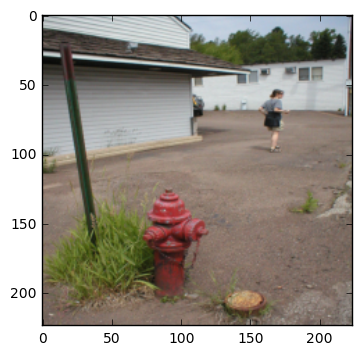

In [14]:
#test net
ckpt = tf.train.get_checkpoint_state(dir_)
print ("loading model: ",ckpt.model_checkpoint_path)
saver.restore(sess, ckpt.model_checkpoint_path)

data = flickr8k.get_batch('val',1)
out = 1
data = shape_data2batchsize(data,batch_size,seq_per_image)

Labels = np.reshape(dense_to_one_hot(np.reshape(data['labels'],(-1)), n_classes=num_label),(batch_size*seq_per_image,seq_length,num_label))
Lengths = data['length']+1
Mask = make_mask(Lengths+1,[batch_size*seq_per_image,seq_length+1])
State =(np.zeros((batch_size*seq_per_image,rnn_size)),np.zeros((batch_size*seq_per_image,rnn_size)))
Loss,out_labels = sess.run((loss,chosen_labels),
          feed_dict={
          x: data['images'],
          y: Labels,
          initial_state[0]:State[0],
          initial_state[1]:State[1],
          mask:Mask,
          lengths:Lengths
            })
setence = ''
for vocab_hot in out_labels[0]:
    if(vocab_hot != 0):
        setence = setence +' '+  flickr8k.getVocab()[str(vocab_hot)]
true_setence = ''
for vocab_hot in data['labels'][0]:
    if(vocab_hot != 0):
        true_setence = true_setence +' '+  flickr8k.getVocab()[str(int(vocab_hot))]
print (Loss)        
print (setence)
print (true_setence)

Labels = np.reshape(dense_to_one_hot(np.reshape(data['labels'],(-1)), n_classes=num_label),(batch_size*seq_per_image,seq_length,num_label))
data['length'][0] = 1
data['length'][1:] = 0
Lengths = data['length']
Mask = make_mask(Lengths+1,[batch_size*seq_per_image,seq_length+1])
State =(np.zeros((batch_size*seq_per_image,rnn_size)),np.zeros((batch_size*seq_per_image,rnn_size)))
image = flickr8k.deprocess_image(data['images'][0])
plt.imshow(image)  
setence = ''
vgg_out,state1,state2,out_labels = sess.run((vgg.fc7(),rnn.state[0],rnn.state[1],chosen_labels),
              feed_dict={
              x: data['images'],
              y: Labels,
              initial_state[0]:State[0],
              initial_state[1]:State[1],
              mask:Mask,
              lengths:Lengths
                })
# print(flickr8k.getVocab()[str(int(out_labels[0,0]))])
setence = setence + flickr8k.getVocab()[str(int(out_labels[0,0]))]

i=0

while(out_labels[0,0] != 0 and i < 16):
    size1_batch = np.reshape(out_labels[0,0],(1,1))
#     size1_batch = np.reshape(data['labels'][0,i],(1,1))
    hot_label = np.concatenate((np.reshape(dense_to_one_hot(size1_batch, n_classes=num_label),(1,1,num_label)),\
                                np.zeros((1,seq_length,num_label), dtype=np.float32)),axis=1)
    padded_hot_label = np.concatenate((hot_label, np.zeros((batch_size*seq_per_image-1,seq_length+1,num_label), dtype=np.float32)), axis=0)
    empty_image_input =np.zeros((batch_size*seq_per_image,seq_length+1,4096),dtype = np.float32) 
    lstm_input = np.concatenate((empty_image_input,padded_hot_label),axis = 2)
    out_labels,state1,state2 = sess.run((chosen_labels,rnn.state[0],rnn.state[1]),feed_dict={
            rnn.x:lstm_input,
            initial_state[0]:state1,
            initial_state[1]:state2,
            #             mask:Mask,
            lengths:Lengths
#             x: data['images'],
#             y: Labels
        })
    if (out_labels[0,0]!=0):
        setence = setence + ' ' + flickr8k.getVocab()[str(int(out_labels[0,0]))]
#         print(flickr8k.getVocab()[str(int(out_labels[0,0]))])
    i+=1 
print (setence)
    